# Kalman filter in reverse time

So here, we will use Kalman filter in reverse time for Linear Gaussian System

$\begin{equation}
 \begin{cases}
   X_t = a_t X_{t-1} + c_t + b_t V_t, t \in N, X_0 \sim N(m_0, D_0)\\
   Y_t = A_t X_t + C_t + B_t W_t \\
   Y_0 = A_0 X_0 + C_0 + B_0 W_0
 \end{cases}
\end{equation}$

$Y$ - observing value, have to estimate $X$

In reverse time we will estimate by next algorithm:

Start:

$\hat{X}_T^r = k_T A_T^T {(A_T k_T A_T^T + B_T B_T^T)}^+ Y_T$

$K_T^r = k_T - k_T A_T^T {(A_T k_T A_T^T + B_T B_T^T)}^+ A_T k_T$

Step:

$\bar{X}_t^r = a_t^r \hat{X}_{t+1}^{r}$

$\bar{K}_t^{r} = a_t^r K_{t+1}^r {(a_t^r)}^T + b_t^r {(b_t^r)}^T$

Correction:

$\hat{X}_t^r = \bar{X}_t^r + \bar{K}_t^r A_T^T {(A_T \bar{K}_t^r A_T^T + B_T B_T^T)}^+ (Y_t - A_t \bar{X}_t^r)$

$K_t^r = \bar{K}_t^r - \bar{K}_t^r A_T^T {(A_T \bar{K}_t^r A_T^T + B_T B_T^T)}^+ A_t \bar{K}_t^r$


Where:

$a_t^r = k_t a_{t+1}^T k_{t+1}^{-1}$

$b_t^r = {(k_t - k_t a_{t+1}^T k_{t+1}^{-1} a_{t+1} k_t)}^{0.5}$


**Note**

As you can see we must have a classic (direct) Kalman Filter to start reverse Filter

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
from scipy import integrate
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 1
%aimport classes.LinearGaussSystem

In [20]:
a = 1
b = 0.5
c = 0
A = 1
B = 1
C = 0
p_0 = ss.norm(loc = 0, scale = 1)
p_v = ss.norm(loc = 0, scale = 1)
p_w = ss.norm(loc = 0, scale = 1)

LGS = classes.LinearGaussSystem.LinearGaussianSystem(a = a, b = b, c = c, A = A, B = B, C = C, p_0 = p_0, p_v = p_v, p_w = p_w)

x = LGS.simulate_x(end=100)
y = LGS.simulate_y()

In [21]:
%%time
x_est = LGS.estimate_x()

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: total: 15.6 ms
Wall time: 14 ms


In [22]:
%%time
x_r_est = LGS.estimate_x_r(LGS.est_cov_list[-1])

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: total: 31.2 ms
Wall time: 16 ms


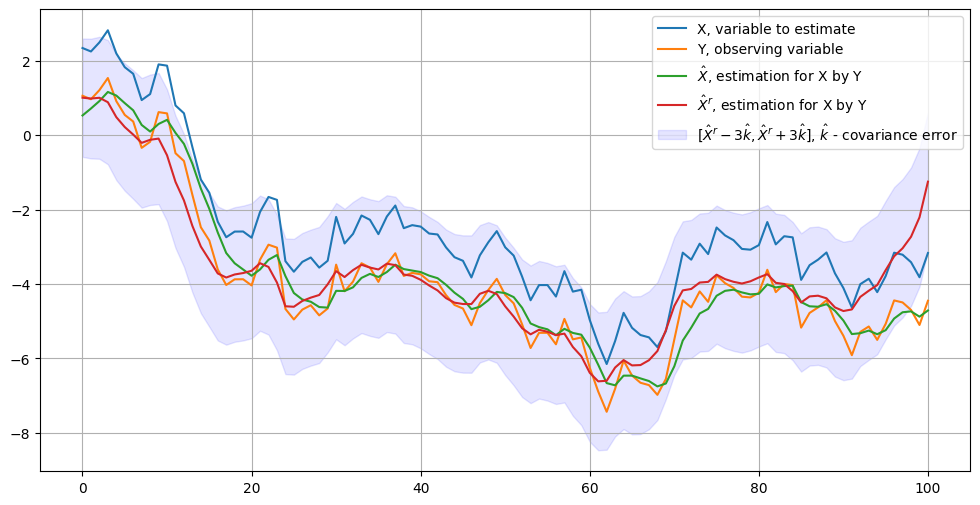

In [23]:
plt.figure(figsize=(12, 6))
plt.grid(True)

t = LGS.time_list
cov_est = LGS.est_cov_r_list
plt.plot(t, x, label='X, variable to estimate')
plt.plot(t, y, label='Y, observing variable')
plt.plot(t, x_est, label="$\hat{X}$, estimation for X by Y")
plt.plot(t, x_r_est, label="$\hat{X}^r$, estimation for X by Y")

plt.fill_between(t, np.array(x_r_est) +  3 *  np.array(cov_est) ** 0.5,
                 np.array(x_r_est) -  3 * np.array(cov_est) ** 0.5, color='blue',
                 alpha= 0.1, label='[$\hat{X}^r - 3 \hat{k}, \hat{X}^r + 3 \hat{k}$], $\hat{k}$ - covariance error' ) 

plt.legend()

## Results

Kalman Reverse Filter is quick and enough efficient for estimation for Linear Gaussian Systems